In [35]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBRFClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
%matplotlib inline

from sklearn.metrics import f1_score, roc_auc_score, precision_score, \
classification_report, precision_recall_curve, confusion_matrix, auc, average_precision_score

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [36]:
df = pd.read_csv("churn_data.csv")
df.head(3)
df.drop(columns=['CustomerId'], inplace=True)

In [37]:
df['Exited'].value_counts()/df.shape[0]*100

0    79.63
1    20.37
Name: Exited, dtype: float64

In [38]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [39]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], stratify=df['Exited'], random_state=99)

### Фунция собирающая пайпалайн

In [40]:
def pipline_prepare(model_status='tree', categorical_columns=[], continuous_columns=[]):
    final_transformers = []
 
    # собираем пайплайн для категориальных признаков который выберает признак и декодирует его
    for cat_col in categorical_columns:
        cat_transformer = Pipeline([
                    ('selector', FeatureSelector(column=cat_col)),
                    ('ohe', OHEEncoder(key=cat_col))])
        final_transformers.append((cat_col, cat_transformer))
        
   
    for cont_col in continuous_columns:
        if model_status == 'tree':
            cont_transformer = Pipeline([
                        ('selector', NumberSelector(key=cont_col))])
            final_transformers.append((cont_col, cont_transformer))
        elif model_status == 'lineral':
            cont_transformer = Pipeline([
                        ('selector', NumberSelector(key=cont_col)),
                ('standartization', StandardScaler())])
            final_transformers.append((cont_col, cont_transformer))
        elif model_status == 'vectors':
            cont_transformer = Pipeline([
                        ('selector', NumberSelector(key=cont_col)),
                    ('minmax', MinMaxScaler())])
            final_transformers.append((cont_col, cont_transformer))
            
            
        
        
    # обьединяем трансформаторы кактегориальных и числовых признаков
    feats = FeatureUnion(final_transformers)
    feature_processing = Pipeline([('feats', feats)])

    return feats

### Сборка пайплайнов в зависимости от природы ML модели

In [41]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

feature_tree = pipline_prepare(categorical_columns=categorical_columns, continuous_columns=continuous_columns)
feature_vectors = pipline_prepare(model_status='vectors', categorical_columns=categorical_columns, continuous_columns=continuous_columns)
feature_lineral = pipline_prepare(model_status='lineral', categorical_columns=categorical_columns, continuous_columns=continuous_columns)

### Словарь метрик для ML модели

In [42]:
def metrics(y_test, preds, score):
    metric_dict = {}
    precision, recall, thresholds = precision_recall_curve(y_test, score)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    metric_dict['thresholds'] = thresholds[ix]
    metric_dict['precision'] = precision[ix]
    metric_dict['recall'] = recall[ix]
    metric_dict['f_score'] = fscore[ix]
    metric_dict['auc_precision_recall'] = auc(recall, precision)
    metric_dict['average_precision'] = average_precision_score(y_test, score)
    return metric_dict


### Pipline обучения модели

In [43]:
def model_train(feature, Classifier):
    pipeline = Pipeline([
        ('features', feature),
        ('classifier', Classifier),
    ])
    pipeline.fit(X_train, y_train)
    score = pipeline.predict_proba(X_test)[:, 1]
    preds = pipeline.predict(X_test)
    return score, preds
    

In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Модели и их метрики

### HistGradientBoostingClassifier

In [45]:
score, preds = model_train(feature_tree, HistGradientBoostingClassifier(random_state=42))
hist = metrics(y_test, preds, score)

### CatBoostClassifier

In [46]:
score, preds = model_train(feature=feature_tree, Classifier=CatBoostClassifier(random_state=42, silent=True))
cat = metrics(y_test, preds, score)

### LGBMClassifier

In [24]:
score, preds = model_train(feature=feature_tree, Classifier=LGBMClassifier(random_state=42) )
lgbm = metrics(y_test, preds, score)

[LightGBM] [Info] Number of positive: 1528, number of negative: 5972
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203733 -> initscore=-1.363122
[LightGBM] [Info] Start training from score -1.363122


### XGBRFClassifier

In [25]:
score, preds = model_train(feature=feature_tree, Classifier=XGBRFClassifier(random_state=42))
xgbd = metrics(y_test, preds, score)

### Метод опорных векторов SVC

In [26]:
score, preds = model_train(feature=feature_vectors, Classifier=SVC(random_state=42, kernel='poly', probability=True))
svm = metrics(y_test, preds, score)

### LogisticRegression

In [27]:
score, preds = model_train(feature_lineral, LogisticRegression(random_state=42))
log = metrics(y_test, preds, score)

### RandomForestClassifier

In [28]:
score, preds = model_train(feature_tree, RandomForestClassifier(random_state=42))
rf =  metrics(y_test, preds, score)

### DecisionTreeClassifier

In [29]:
score, preds = model_train(feature_tree, DecisionTreeClassifier(random_state=42))
tree =  metrics(y_test, preds, score)

### GaussianNB

In [30]:
score, preds = model_train(feature_tree, GaussianNB())
bayas =  metrics(y_test, preds, score)

### KNeighborsClassifier

In [31]:
score, preds  = model_train(feature_vectors, KNeighborsClassifier())
neigbors =  metrics(y_test, preds, score)

### Итоговая таблица признаков

In [32]:
metrics_df = pd.DataFrame(hist.values(), index=hist.keys(), columns=['HistGradientBoostingClassifier'])
metrics_df.insert(loc=len(metrics_df.columns), column='CatBoostClassifier', value=cat.values())
metrics_df.insert(loc=len(metrics_df.columns), column='XGBRFClassifier', value=xgbd.values())
metrics_df.insert(loc=len(metrics_df.columns), column='LGBMClassifier', value=lgbm.values())
metrics_df.insert(loc=len(metrics_df.columns), column='RandomForestClassifier', value=rf.values())
metrics_df.insert(loc=len(metrics_df.columns), column='DecisionTreeClassifier', value=tree.values())
metrics_df.insert(loc=len(metrics_df.columns), column='LogisticRegression', value=log.values())
metrics_df.insert(loc=len(metrics_df.columns), column='SVC', value=svm.values())
metrics_df.insert(loc=len(metrics_df.columns), column='GaussianNB', value=bayas.values())
metrics_df.insert(loc=len(metrics_df.columns), column='KNeighborsClassifier', value=neigbors.values())
metrics_df

,HistGradientBoostingClassifier,CatBoostClassifier,XGBRFClassifier,LGBMClassifier,RandomForestClassifier,DecisionTreeClassifier,LogisticRegression,SVC,GaussianNB,KNeighborsClassifier
thresholds,0.359707,0.377792,0.297498,0.300170,0.380000,1.000000,0.260801,0.182361,0.231820,0.200000
precision,0.666667,0.695067,0.616981,0.624762,0.687927,0.519553,0.441088,0.496997,0.428571,0.280395
recall,0.609037,0.609037,0.642436,0.644401,0.593320,0.548134,0.573674,0.650295,0.583497,0.724951
f_score,0.636550,0.649215,0.629451,0.634429,0.637131,0.533461,0.498719,0.563404,0.494176,0.404384
auc_precision_recall,0.702436,0.715994,0.697524,0.702391,0.680977,0.579843,0.459144,0.601163,0.378240,0.355542
average_precision,0.702707,0.716262,0.697717,0.702673,0.677257,0.376784,0.460560,0.601768,0.379539,0.312952


По умолчянию более точной моделью по метрике PR auc оказалась модель градиентного бустинга CatBoostClassifier. Далее подберем для нее гиперпараметры

#### Оценку экономической эффективности

In [80]:
def bussines_metrics(cnf_matrix):
    TP = cnf_matrix[0][0]
    TN = cnf_matrix[1][1]
    
    FN = cnf_matrix[0][1]
    FP = cnf_matrix[1][0]
      
    money = TP*2 + TN*1+ FN*2
    return money
   

### Лучшая модель по умолчанию и ее бизнес метрика

In [49]:
score, preds = model_train(feature=feature_tree, Classifier=CatBoostClassifier(random_state=42, silent=True))
cat = metrics(y_test, preds, score)

Confusion matrix, without normalization
[[1859  132]
 [ 209  300]]


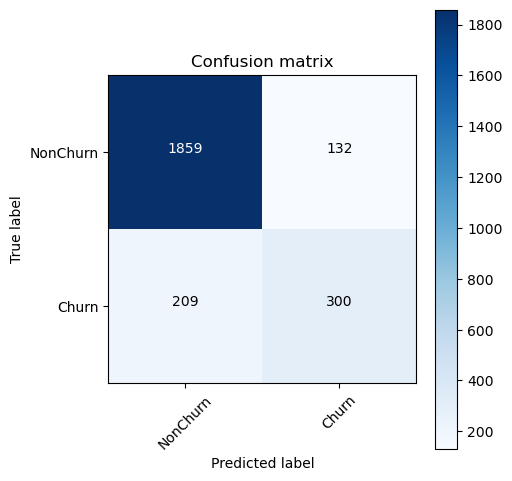

In [82]:
font = {'size' : 10}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, score>cat['thresholds'])
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [83]:
money_cat_1 = bussines_metrics(cnf_matrix)
print(f'Прибыль при использовании CatBoostClassifier по умолчанию $ - {money_cat_1}')

Прибыль при использовании CatBoostClassifier по умолчанию $ - 4282


### Подбор параметров для модели CatBoostClassifier 

In [418]:
params = { 
          'max_depth': list(range(3,9,1)),
          'n_estimators': list(range(1500,1800,20)),
         }

cat = CatBoostClassifier(silent=True, random_state=42)
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [365]:
pipeline_for_cat = Pipeline([
    ('features', feature_tree)])
X_matrix_train = pipeline_for_cat.fit_transform(X_train)

In [372]:
%%time
grid = RandomizedSearchCV(cat, params, scoring='average_precision', cv=cv, n_jobs=-1)
grid.fit(X_matrix_train, y_train)

CPU times: total: 33.6 s
Wall time: 1min 47s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000022115922CD0>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7, 8],
                                        'n_estimators': [1500, 1520, 1540, 1560,
                                                         1580, 1600, 1620, 1640,
                                                         1660, 1680, 1700, 1720,
                                                         1740, 1760, 1780]},
                   scoring='average_precision')

In [373]:
grid.best_params_

{'n_estimators': 1500, 'max_depth': 4}

In [374]:
grid.best_score_

0.7066575699227563

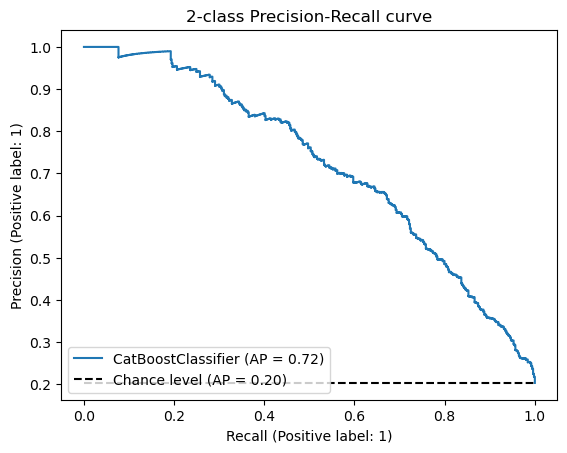

In [55]:
from sklearn.metrics import PrecisionRecallDisplay

cat_pf = Pipeline([
        ('features', feature_tree),
        ('classifier', CatBoostClassifier(silent=True,  random_state=42, max_depth = 4,n_estimators =1500)),
    ])
cat_pf.fit(X_train, y_train)

display = PrecisionRecallDisplay.from_estimator(cat_pf, X_test, y_test, name="CatBoostClassifier", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 

In [84]:
preds = cat_pf.predict(X_test)
score = cat_pf.predict_proba(X_test)[:, 1]
cat_f = metrics(y_test, preds, score)
cat_f

{'thresholds': 0.31030425752985313,
 'precision': 0.6520076481835564,
 'recall': 0.6699410609037328,
 'f_score': 0.6608527131782946,
 'auc_precision_recall': 0.7220502099212183,
 'average_precision': 0.7223084359511937}

Confusion matrix, without normalization
[[1809  182]
 [ 169  340]]


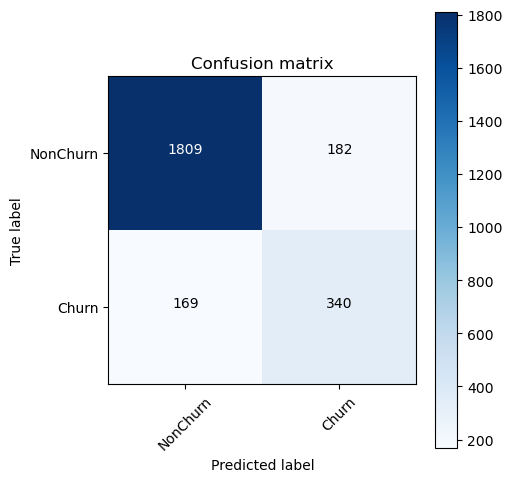

In [85]:
font = {'size' : 10}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, score>cat_f['thresholds'])
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [86]:
money_cat_2 = bussines_metrics(cnf_matrix)

print(f'Прибыль при использовании CatBoostClassifier по c подобранными гиперпараметрами $ - {money_cat_2}')

Прибыль при использовании CatBoostClassifier по c подобранными гиперпараметрами $ - 4322


In [87]:
money_perf_model = y_test.value_counts()[0]*2+y_test.value_counts()[1]*1
print(f'Прибыль при использовании идеальной модели $ - {money_perf_model}')

Прибыль при использовании идеальной модели $ - 4491


In [88]:
print(f'Оптимизированая модель зарабатывает на {money_cat_2 - money_cat_1} $ больше ')

Оптимизированая модель зарабатывает на 40 $ больше 


In [89]:
print(f'Оптимизированая модель не способна дозаработать $ {money_perf_model - money_cat_2} по сравнению с идеальной  ')


Оптимизированая модель не способна дозаработать $ 169 по сравнению с идеальной  


In [90]:
print('Эконмическое кпд модели % - ')
round(money_cat_2*100/money_perf_model,2)

Эконмическое кпд модели % - 


96.24